厳密対角化のコード(Stateは定義せずにOpは定義するVer)

In [1]:
module ExactDiag
using LinearAlgebra
using PrettyTables
const _dim = Ref(1)
const _site = Ref(1)
export init, Op, spin_op, id, shift, site_flip, spin_flip, sum_j, block_diag, diag, energy_gap
#初期化
function init(dimention::Int, site_number::Int)
  _dim[] = dimention
  _site[] = site_number
end

#region 進数変換
function Nary_trans(t::Int)
  if t == -1
    return [-1 for _ in 1:_site[]]
  end
  if t < 0 || t >= _dim[]^_site[]
    throw(ArgumentError("t must be in the range [0, dim^site - 1]"))
  end
  dimention = _dim[]
  site_number = _site[]
  n = Vector{Int}(undef, site_number)
  for i in 1:site_number
    n[site_number+1-i] = t % dimention
    t = div(t, dimention)
  end
  n
end
function Nary_reverse(n::Vector{Int})
  t = 0
  c = 1
  dimention = _dim[]
  site_number = _site[]
  for i in 1:site_number
    if n[site_number+1-i] < 0 || n[site_number+1-i] >= dimention
      return -1
    end
    t += n[site_number+1-i] * c
    c *= dimention
  end
  t
end
#endregion

#region 演算子関係の関数
struct Op
  op::Vector{Tuple{ComplexF64,Vector{Function}}}
  function Op(op::Vector{Tuple{ComplexF64,Vector{Function}}})
    new(op)
  end
  function Op(op1::Function)
    vecf = Vector{Function}([op1])
    Op([(1.0 + 0.0im, vecf)])
  end
end
function f_op(f::Function)
  Op(f)
end
function spin_op(kind::Char, site::Int)
  site_number = _site[]
  if kind == '+'
    function plus(t::Int)
      n = Nary_trans(t)
      n[(site-1)%site_number+1] += 1
      return (1.0 + 0.0im, Nary_reverse(n))
    end
    return f_op(plus)
  elseif kind == '-'
    function minus(t::Int)
      n = Nary_trans(t)
      n[(site-1)%site_number+1] -= 1
      return (1.0 + 0.0im, Nary_reverse(n))
    end
    return f_op(minus)
  elseif kind == 'z'
    function z(t::Int)
      n = Nary_trans(t)
      return (n[(site-1)%site_number+1] % 2 == 0 ? 0.5 + 0.0im : -0.5 + 0.0im, t)
    end
    return f_op(z)
  else
    throw(ArgumentError("kind must be '+', '-', or 'z'"))
  end
end
function id(t::Int)
  return (1.0 + 0.0im, t)
end
id() = f_op(id)
function shift(k::Int=1)
  function shift1(t::Int)
    n = Nary_trans(t)
    n1 = circshift(n, k)
    return (1.0 + 0.0im, Nary_reverse(n1))
  end
  return f_op(shift1)
end
function site_flip(t::Int)
  n=Nary_trans(t)
  n1=reverse(n)
  return (1.0 + 0.0im, Nary_reverse(n1))
end
site_flip() = f_op(site_flip)
function spin_flip(t::Int)
  if _dim[] != 2
    throw(ArgumentError("spin_flip is only defined for dim=2"))
  end
  n = Nary_trans(t)
  n1 = Vector{Int}(undef, _site[])
  for i in 1:_site[]
    if n[i] == 0
      n1[i] = 1
    elseif n[i] == 1
      n1[i] = 0
    else
      throw(ArgumentError("spin_flip is only defined for dim=2"))
    end
  end
  return (1.0 + 0.0im, Nary_reverse(n1))
end
spin_flip() = f_op(spin_flip)
#endregion

#region 演算子の演算
import Base: *, +, -
function +(ops::Op...)
  k = Vector{Tuple{ComplexF64,Vector{Function}}}()
  for op1 in ops
    k = vcat(k, op1.op)
  end
  Op(k)
end
function *(op1::Op)
  op1
end
function *(op1::Op, op2::Op...)
  op3 = *(op2...)
  k = Vector{Tuple{ComplexF64,Vector{Function}}}()
  for op11 in op1.op
    for op31 in op3.op
      push!(k, (op11[1] * op31[1], vcat(op11[2], op31[2])))
    end
  end
  Op(k)
end
function *(coeff::Union{ComplexF64,Float64}, op1::Op...)
  op2 = *(op1...)
  k = Vector{Tuple{ComplexF64,Vector{Function}}}()
  for op21 in op2.op
    push!(k, (op21[1] * coeff, op21[2]))
  end
  Op(k)
end
function -(op1::Op)
  (-1.0 + 0.0im) * op1
end
function -(op1::Op, op2::Op)
  op1 + (-op2)
end
function -(op1::Op, op2::Op...)
  op3 = +(op2...)
  op1 - op3
end
function sum_j(mats::Op...)
  ans = mats[1]
  for mat in mats[2:end]
    ans += mat
  end
  ans
end# サイト数以外の任意のiで回す場合にはsum_j(Tuple(f(i) for i in 1:4)...)のように書いて内包表記
function sum_j(f::Function)
  sum_j(Tuple(f(i) for i in 1:_site[])...)
end# サイト数で回す場合にはsum_j(i->f(i))のように書く
#endregion

#region ブロック対角化とその準備
function mat_gene(op1::Union{Matrix{ComplexF64},Op})
  if isa(op1, Matrix{ComplexF64})
    return op1
  end
  dimention = _dim[]
  site_number = _site[]
  mat = zeros(ComplexF64, dimention^site_number, dimention^site_number)
  for t in 0:dimention^site_number-1
    for (coeff, op11) in op1.op
      t1 = t
      coeff1 = coeff
      for op12 in op11
        (v1, t1) = op12(t1)
        coeff1 *= v1
      end
      if t1 >= 0 && t1 < dimention^site_number
        mat[t+1, t1+1] += coeff1
      end
    end
  end
  mat
end
function nthroots(z::ComplexF64, n::Int)
  if n == 2 && abs(imag(z)) < 1.0e-10 && real(z) > 1.0e-10
    return [-sqrt(real(z)) + 0.0im, sqrt(real(z)) + 0.0im]
  end
  r = abs(z)
  θ = angle(z)
  roots = Vector{ComplexF64}(undef, n)
  for k in 1:n
    if n / k == 2 && abs(imag(z)) < 1.0e-10 && real(z) > 1.0e-10
      roots[k] = -sqrt(real(z)) + 0.0im
      continue
    end
    if n == k
      roots[k] = r^(1 / n) * cis(θ / n)
      continue
    end
    roots[k] = r^(1 / n) * cis(θ / n + 2π * ((n / k)^(-1)))
  end
  return roots
end
function diag(op1::Op)
  mat1= mat_gene(op1)
  energy,eigens1 = eigen(mat1)
  return energy
end
function vcat_energy(energy1::Union{Vector{Float64},Vector{ComplexF64}}, energy2::Union{Vector{Float64},Vector{ComplexF64}})
  energy3=Vector{Float64}()
  for i in energy1
    if abs(imag(i)) > 1.0e-10
      throw(ArgumentError("The input vector contains complex numbers."))
    end
    push!(energy3, real(i))
  end
  for i in energy2
    if abs(imag(i)) > 1.0e-10
      throw(ArgumentError("The input vector contains complex numbers."))
    end
    push!(energy3, real(i))
  end
  return energy3
end
function block_diag(kind::String, op1::Op, op2::Op=id())
  mat1 = mat_gene(op1)
  site_number = _site[]
  dimention = _dim[]
  if kind == "u1"
    energy = Vector{Float64}()
    nn1 = [Vector{Int}() for i in 0:site_number*(dimention-1)]
    for t in 0:dimention^site_number-1
      push!(nn1[sum(Nary_trans(t))+1], t)
    end
    for n2 in nn1
      n2_len = length(n2)
      mat2 = zeros(ComplexF64, n2_len, n2_len)
      for i in 1:n2_len
        for j in 1:n2_len
          mat2[i, j] = mat1[n2[i]+1, n2[j]+1]
        end
      end
      if n2_len == 1
        if abs(imag(mat2[1, 1])) > 1.0e-10
          throw(ArgumentError("The matrix is not diagonalizable."))
        end
        push!(energy, real(mat2[1, 1]))
        continue
      end
      energy1, eigens1 = eigen(mat2)
      energy = vcat_energy(energy, energy1)
    end
    return energy
  elseif kind == "z2"
    energy = Vector{Float64}()
    nn1 = Vector{Vector{Int}}()
    dim_tot = dimention^site_number
    set_int = Set{Int}()
    count = 0
    for t in 0:dim_tot-1
      if t in set_int
        continue
      end
      count += 1
      push!(nn1, Vector{Int}())
      push!(nn1[count], t)
      push!(set_int, t)
      t1 = copy(t)
      for i in 1:2
        t1 = op2.op[1][2][1](t1)[2]
        if t == t1
          break
        end
        push!(nn1[count], t1)
        push!(set_int, t1)
      end
    end
    nthroot1 = nthroots(1.0 + 0.0im, 2)
    nn1_len = length(nn1)
    for i in 1:2
      c = 0
      for j in 1:nn1_len
        if (i * length(nn1[j])) % 2 != 0
          continue
        end
        c += 1
      end
      mat2 = zeros(ComplexF64, c, c)
      c1 = 0
      for j in 1:nn1_len
        if (i * length(nn1[j])) % 2 != 0
          continue
        end
        c1 += 1
        c2 = 0
        for k in 1:nn1_len
          if (i * length(nn1[k])) % 2 != 0
            continue
          end
          c2 += 1
          mat2_pat = 0.0 + 0.0im
          n2_len = length(nn1[j])
          for l in 1:n2_len
            mat2_pat += sqrt(length(nn1[k]) / length(nn1[j])) * mat1[nn1[j][l]+1, nn1[k][1]+1] * nthroot1[(i*(l-1)+2-1)%2+1]
          end
          mat2[c1, c2] = mat2_pat
        end
      end
      energy1, eigens1 = eigen(mat2)
      energy = vcat_energy(energy, energy1)
    end
    return energy
  elseif kind == "shift"
    energy = Vector{Float64}()
    nn1 = Vector{Vector{Int}}()
    dim_tot = dimention^site_number
    set_int = Set{Int}()
    count = 0
    for t in 0:dim_tot-1
      if t in set_int
        continue
      end
      count += 1
      push!(nn1, Vector{Int}())
      push!(nn1[count], t)
      push!(set_int, t)
      t1 = copy(t)
      for i in 1:site_number
        t1 = op2.op[1][2][1](t1)[2]
        if t == t1
          break
        end
        push!(nn1[count], t1)
        push!(set_int, t1)
      end
    end
    nthroot1 = nthroots(1.0 + 0.0im, site_number)
    nn1_len = length(nn1)
    for i in 1:site_number
      c = 0
      for j in 1:nn1_len
        if (i * length(nn1[j])) % site_number != 0
          continue
        end
        c += 1
      end
      mat2 = zeros(ComplexF64, c, c)
      c1 = 0
      for j in 1:nn1_len
        if (i * length(nn1[j])) % site_number != 0
          continue
        end
        c1 += 1
        c2 = 0
        for k in 1:nn1_len
          if (i * length(nn1[k])) % site_number != 0
            continue
          end
          c2 += 1
          mat2_pat = 0.0 + 0.0im
          n2_len = length(nn1[j])
          for l in 1:n2_len
            mat2_pat += sqrt(length(nn1[k]) / length(nn1[j])) * mat1[nn1[j][l]+1, nn1[k][1]+1] * nthroot1[(i*(l-1)+site_number-1)%site_number+1]
          end
          mat2[c1, c2] = mat2_pat
        end
      end
      energy1, eigens1 = eigen(mat2)
      energy = vcat_energy(energy, energy1)
    end
    return energy
  elseif kind == "u1z2"
  elseif kind == "u1shift"
  elseif kind == "z2shift"
  elseif kind == "u1z2shift"
  else
    throw(ArgumentError("kind must be 'u1', 'z2', 'shift', 'u1z2', 'u1shift', 'z2shift', or 'u1z2shift'"))
  end
end
#endregion
function energy_gap(energys::Vector{Float64})
  if length(energys) < 3
    throw(ArgumentError("energys must contain at least three elements"))
  end
  sorted_energies = sort(unique(energys))
  s=0.0
  for i in 1:length(sorted_energies)-2
    a=sorted_energies[i+1] - sorted_energies[i]
    b=sorted_energies[i+2] - sorted_energies[i+1]
    if max(a,b) == 0.0
      continue
    end
    s += min(a,b)/max(a,b)
  end
  return s / (length(sorted_energies) - 2)
end
end

Main.ExactDiag

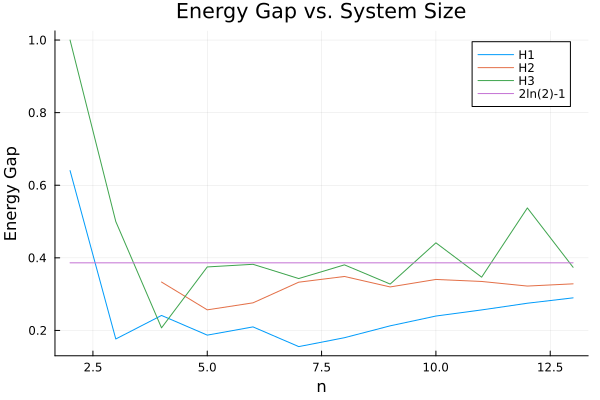

In [5]:
using .ExactDiag
using Plots
hj=1.0
Δ=1.0
x=Vector{Float64}()
y1=Vector{Float64}()
y2=Vector{Float64}()
y3=Vector{Float64}()
y4=Vector{Float64}()
for n in 2:13
  push!(x, float(n))
  init(2, n)
  H1 = sum_j(j->0.5*spin_op('z',j)*spin_op('z',j+1) - 0.5*hj*(spin_op('+',j) + spin_op('-',j)))
  H2=sum_j(j->0.25*(spin_op('+',j)*spin_op('-',j+1)+spin_op('-',j)*spin_op('+',j+1))+0.5*Δ*spin_op('z',j)*spin_op('z',j+1))
  H3=-1.0/2.0*sum_j(j->-0.5*(spin_op('+',j)*spin_op('-',j+1)+spin_op('-',j)*spin_op('+',j+1)))
  push!(y1,energy_gap(block_diag("shift", H1, shift())))
  push!(y2,energy_gap(block_diag("shift", H2, shift())))
  push!(y3,energy_gap(block_diag("shift", H3, shift())))
  push!(y4,2.0*log(exp(1.0),2.0)-1.0)
end
plot(
  x, [y1 y2 y3 y4];
  labels    = ["H1" "H2" "H3" "2ln(2)-1"],
  xlabel    = "n",
  ylabel    = "Energy Gap",
  title     = "Energy Gap vs. System Size"
)


nサイトの横磁場Ising模型
$$
\hat{H}=\frac{J}{2}\sum_j\left(\hat{S}^z_j\hat{S}^z_{j+1}-\frac{h}{J}(\hat{S}^+_j+\hat{S}^-_j)\right)\\
\frac{h}{J}=1
$$

In [2]:
using .ExactDiag
hj=1.0
n=3
init(2, n)
H = sum_j(j->0.5*spin_op('z',j)*spin_op('z',j+1) - 0.5*hj*(spin_op('+',j) + spin_op('-',j)))
println(diag(H))
println("z2対称性")
println(block_diag("z2", H, site_flip()))
println(block_diag("z2", H, spin_flip()))
println("並進対称性")
println(block_diag("shift", H, shift()))

[-1.520643923738955, -0.6249999999999994, -0.6249999999999992, -0.2763878188659965, 0.37499999999999994, 0.37500000000000006, 0.7706439237389611, 1.5263878188659974]
z2対称性
[-0.625, 0.375, -1.5206439237389546, -0.6249999999999998, -0.2763878188659967, 0.375, 0.7706439237389612, 1.5263878188659974]
[-0.6249999999999999, -0.6249999999999999, -0.2763878188659971, 1.5263878188659938, -1.5206439237389582, 0.37499999999999994, 0.375, 0.7706439237389602]
並進対称性
[-0.6249999999999999, 0.37499999999999994, -0.6250000000000001, 0.3749999999999999, -1.520643923738955, -0.2763878188659965, 0.7706439237389611, 1.5263878188659974]


In [ ]:
using .ExactDiag
hj=1.0
n=12
init(2, n)
H = sum_j(j->0.5*spin_op('z',j)*spin_op('z',j+1) - 0.5*hj*(spin_op('+',j) + spin_op('-',j)))
@time diag(H)
println("z2対称性")
@time block_diag("z2", H, site_flip())
@time block_diag("z2", H, spin_flip())
println("並進対称性")
@time block_diag("shift", H, shift())
println("")

 43.692370 seconds (2.86 M allocations: 1.101 GiB, 0.84% gc time)
z2対称性
 15.312700 seconds (2.88 M allocations: 873.453 MiB, 0.70% gc time)
 15.135749 seconds (2.88 M allocations: 873.323 MiB, 0.59% gc time)
並進対称性
  4.829950 seconds (2.88 M allocations: 430.639 MiB, 0.62% gc time)



nサイトのXXZ模型
$$
\hat{H}=J\sum_j\left[\frac{1}{4}(\hat{S}_j^+ \hat{S}_{j+1}^- +\hat{S}_j^- \hat{S}_{j+1}^+)+\frac{1}{2}\Delta\hat{S}_j^z \hat{S}_{j+1}^z\right]\\
\Delta=1
$$

In [4]:
using .ExactDiag
Δ=1.0
n=2
init(2, n)
H = sum_j(j->0.25*(spin_op('+',j)*spin_op('-',j+1)+spin_op('-',j)*spin_op('+',j+1))+0.5*Δ*spin_op('z',j)*spin_op('z',j+1))
println(diag(H))
println("u1対称性")
println(block_diag("u1", H))
println("z2対称性")
println(block_diag("z2", H, site_flip()))
println(block_diag("z2", H, spin_flip()))
println("並進対称性")
println(block_diag("shift", H, shift()))

[-0.7499999999999994, 0.25, 0.25, 0.25]
u1対称性
[0.25, -0.75, 0.25, 0.25]
z2対称性
[-0.75, 0.25, 0.25, 0.25]
[-0.75, 0.25, 0.25, 0.25]
並進対称性
[-0.75, 0.25, 0.25, 0.25]


In [5]:
using .ExactDiag
Δ=1.0
n=12
init(2, n)
H = sum_j(j->0.25*(spin_op('+',j)*spin_op('-',j+1)+spin_op('-',j)*spin_op('+',j+1))+0.5*Δ*spin_op('z',j)*spin_op('z',j+1))
@time diag(H)
println("u1対称性")
@time block_diag("u1", H)
println("z2対称性")
@time block_diag("z2", H, site_flip())
@time block_diag("z2", H, spin_flip())
println("並進対称性")
@time block_diag("shift", H, shift())
println("")

 38.005932 seconds (3.65 M allocations: 1.137 GiB, 0.22% gc time)
u1対称性
  4.423291 seconds (3.65 M allocations: 562.148 MiB)
z2対称性
 15.118470 seconds (3.68 M allocations: 910.289 MiB, 2.13% gc time)
 15.927701 seconds (3.68 M allocations: 910.158 MiB, 0.66% gc time)
並進対称性
  3.896795 seconds (3.67 M allocations: 467.475 MiB, 3.85% gc time)



nサイトのXY模型
$$
\hat{H}=-\frac{J}{2}\sum_j(\hat{S}^+_j\hat{S}^-_{j+1}+\hat{S}^-_j\hat{S}^+_{j+1})
$$

In [6]:
using .ExactDiag
n=2
init(2, n)
H=-1.0/2.0*sum_j(j->-0.5*(spin_op('+',j)*spin_op('-',j+1)+spin_op('-',j)*spin_op('+',j+1)))
println(diag(H))
println("u1対称性")
println(block_diag("u1", H))
println("z2対称性")
println(block_diag("z2", H, site_flip()))
println(block_diag("z2", H, spin_flip()))
println("並進対称性")
println(block_diag("shift", H, shift()))

[-0.49999999999999944, 0.0, 0.0, 0.5]
u1対称性
[0.0, -0.5, 0.5, 0.0]
z2対称性
[-0.5, 0.0, 0.0, 0.5]
[-0.5, 0.0, 0.0, 0.5]
並進対称性
[-0.5, 0.0, 0.0, 0.5]


In [7]:
using .ExactDiag
n=12
init(2, n)
H=-1.0/2.0*sum_j(j->-0.5*(spin_op('+',j)*spin_op('-',j+1)+spin_op('-',j)*spin_op('+',j+1)))
@time diag(H)
println("u1対称性")
@time block_diag("u1", H)
println("z2対称性")
@time block_diag("z2", H, site_flip())
@time block_diag("z2", H, spin_flip())
println("並進対称性")
@time block_diag("shift", H, shift())
println("")

 43.419936 seconds (2.22 M allocations: 1.088 GiB, 0.33% gc time)
u1対称性
  3.240800 seconds (2.23 M allocations: 512.647 MiB, 1.25% gc time)
z2対称性
 13.482620 seconds (2.25 M allocations: 860.788 MiB, 0.51% gc time)
 15.712840 seconds (2.25 M allocations: 860.658 MiB)
並進対称性
  3.965448 seconds (2.25 M allocations: 417.974 MiB, 8.40% gc time)

